# Input Description

Job  Machine
3    5
Job# Machine#   M1     M2     M3            VG
1    3          1  10  2  30  3  20         1
1    4          1  12  5  13  3  21  4  28  2
1    3          1  21  2  10  3  11         3

3 5
1 3 1 10 2 30 3 20 1
1 4 1 12 5 13 3 21 4 28 2
1 3 1 21 2 10 3 11 3

# Data Parsing

In [13]:
def readFile(filePath):
    with open(filePath) as fp:
        line = fp.readline()
        nm = line.strip().split()
        machineCnt = nm[1]
        jobs = []
        machines = []
        processing_time = []
        VG = []

        for i in range(int(nm[0])):
            line = fp.readline()
            cv = list(map(int, line.split()))
            operations = []
            machine_l = []
            times = []
            j = 1
            while j < len(cv):
                # 각 op 별 machine, processing_time 할당
                k = cv[j]
                operation = []
                for kj in range(k):
                    j = j + 1
                    if (j >= len(cv)):
                        break;
                    # machine 할당
                    machine = cv[j]
                    j = j + 1
                    # processing_time 할당
                    processing_t = cv[j]
                    machine_l.append(machine)
                    processing_time.append(processing_t)
                    operation.append({'machine': machine, 'processingTime': processing_t})
                j = j + 1
                operations.append(operation)
            machines.append(machine_l)

            # VG 할당
            if (j > len(cv)):
                VG.append(int(cv[-1]))

            jobs.append(operations)
    return jobs, VG, machines, processing_time, {'machineCnt': int(machineCnt), 'jobs': jobs}


In [14]:
jobs, VG, machines, processing_time, jobDicts = readFile("./test_data.txt")

# Population Generation

In [15]:
import random

def generateN(jobDicts, VG):
    N = []
    job_n = 0
    if (len(VG) > 0):    
        for v in VG:
            for i in range(v):
                N.append(job_n)
            job_n += 1

        random.shuffle(N)
    else:
        jobs = jobDicts['jobs']
        i = 0
        for job in jobs:
            for op in job:
                N.append(i)
            i = i+1

        random.shuffle(N)
    return N

In [16]:
def generateM(jobDicts, VG):
    M = []
    if(len(VG) > 0):
        cnt = 0
        for v in VG:
            for i in range(v):
                random.shuffle(machines[cnt])
                M.append(machines[cnt][i])
            cnt += 1
    else:
        jobs = jobDicts['jobs']
        cnt = 0
        for job in jobs:
            for op in job:
                cnt += 1
                randomMachine = random.randint(0, len(op)-1)
                M.append(randomMachine)
    return M

In [17]:
def initial_generation(jobDicts, VG):
    pop_gen = []
    for i in range(10):
        NS = generateN(jobDicts, VG)
        MS = generateM(jobDicts, VG)
        pop_gen.append((NS, MS))

    return pop_gen

In [18]:
parameter = initial_generation(jobDicts,VG) # NS MS
parameter

[([2, 2, 1, 0, 2, 1], [3, 5, 1, 2, 1, 3]),
 ([1, 1, 2, 0, 2, 2], [3, 4, 5, 3, 3, 3]),
 ([2, 1, 2, 2, 0, 1], [3, 3, 3, 2, 3, 2]),
 ([0, 2, 1, 1, 2, 2], [1, 1, 5, 2, 3, 2]),
 ([2, 2, 1, 0, 1, 2], [2, 4, 5, 1, 2, 3]),
 ([2, 1, 2, 2, 1, 0], [1, 1, 1, 1, 2, 2]),
 ([1, 2, 0, 2, 2, 1], [2, 5, 4, 3, 1, 3]),
 ([1, 0, 2, 1, 2, 2], [2, 4, 1, 1, 2, 3]),
 ([1, 2, 2, 2, 0, 1], [1, 4, 3, 2, 2, 2]),
 ([2, 0, 1, 1, 2, 2], [1, 4, 3, 1, 2, 3])]

# Calculate Makespan

In [19]:
# VG 별 machine 나누기
def split_by_machine(VG, param, jobDicts):
    (n,m) = param
    job_lists = []
    current = 0
    if(len(VG) > 0):
        for v in VG:
            append_l = []
            for i in range(v):
                append_l.append(m[current])
                current += 1
            job_lists.append(append_l)
    else:
        current = 0
        for index, job in enumerate(jobDicts['jobs']):
            job_lists.append(m[current:current+len(job)])
            current += len(job)

    return job_lists

In [20]:
def is_free(tab, start, duration):
    for k in range(start, start+duration):
        if not tab[k]:
            return False
    return True

def find_first_proc_time(start_ctr, duration, machine_jobs):
    max_duration_list = []
    max_duration = start_ctr + duration

    if machine_jobs:
        for job in machine_jobs:
            max_duration_list.append(job[2] + job[1]) 

        max_duration = max(max(max_duration_list), start_ctr) + duration

    machine_used = [True] * max_duration

    for job in machine_jobs:
        start = job[2]
        long = job[1]
        for k in range(start, start + long):
            machine_used[k] = False

    for k in range(start_ctr, len(machine_used)):
        if is_free(machine_used, k, duration):
            return k

def calculateMakespan(mo):
    max_per_machine = []
    for machine in mo:
        max_d = 0
        for job in machine:
            end = job[2]
            if end > max_d:
                max_d = end
        max_per_machine.append(max_d)
    
    return max(max_per_machine)

In [47]:
def calculateMakespan(cpl, jobDicts):
    times_taken = getMakespans(cpl, jobDicts)
    
    max_per_machine = []
    for machine in times_taken:
        max_d = 0
        for job in machine:
            end = job[2]
            if end > max_d:
                max_d = end
        max_per_machine.append(max_d)
    return max(max_per_machine)

In [54]:
def getMakespans(cpl, jobDicts):
    o = jobDicts['jobs']
    (n, m) = cpl

    cnt = 0
    ops = [[] for i in range(jobDicts['machineCnt'])]
    time_taken = [[] for i in range(jobDicts['machineCnt'])]
    m_splits = split_by_machine(VG, (n, m), jobDicts)

    outer_shell = [0] * len(m_splits)
    time_outer_shell = [0] * len(m_splits)

    for i in n:
        idx_m = m_splits[i][outer_shell[i]]
        idx_m = idx_m-1

        if (len(VG) > 0):
            machine = [i['machine'] for i in o[i][0] if i['machine']==idx_m+1][0]
            proc_t = [i['processingTime'] for i in o[i][0] if i['machine']==idx_m+1][0]
        else: 
            machine = o[i][outer_shell[i]][idx_m]['machine']
            proc_t = o[i][outer_shell[i]][idx_m]['processingTime']
        start_t = time_outer_shell[i]

        outer_shell[i] += 1    
        tag = "{}-{}".format(i, outer_shell[i]+1)
        if(len(time_taken[machine-1])>0):
            time = (start_t + proc_t)
            lng = len(time_taken[machine-1])-1
            time = time_taken[machine-1][lng] + time
            time_taken[machine-1].append(time)
            ops[machine-1].append((tag, time_taken[machine-1][lng], time))
        else:
            time_taken[machine-1].append((start_t + proc_t))
            ops[machine-1].append((tag, start_t, (start_t + proc_t)))
    
    # calc = calculateMakespan(ops)
    
    return ops




In [55]:
sortedPop = sorted(parameter, key=lambda cpl: calculateMakespan(cpl, jobDicts))

# minimum makespan population
sortedPop[0][0], sortedPop[0][1]

([0, 2, 1, 1, 2, 2], [1, 1, 5, 2, 3, 2])

def getMakespans(cpl, jobDicts):
    o = jobDicts['jobs']
    (n, m) = cpl

    cnt = 0
    ops = [[] for i in range(jobDicts['machineCnt'])]
    m_splits = split_by_machine(VG, (n, m), jobDicts)

    outer_shell = [0] * len(m_splits)
    time_outer_shell = [0] * len(m_splits)

    for i in n:
        idx_m = m_splits[i][outer_shell[i]]
        idx_m = idx_m-1

        machine = o[i][outer_shell[i]][idx_m]['machine']
        proc_t = o[i][outer_shell[i]][idx_m]['processingTime']
        start_t = time_outer_shell[i]
        
        if(len(ops[i]) == 0):
            start = 0
        else:
            start = find_first_proc_time(start_t, proc_t, ops[machine-1])
        tag = "{}-{}".format(i, machine)
        # print(start, start_t, proc_t, machine)
        ops[machine-1].append((tag, proc_t, start_t, machine))

        outer_shell[i] += 1
        time_outer_shell[i] = (start + proc_t)
        
        

    mo = ops
    calc = calculateMakespan(mo)
    print(calc, ops)
    return ops
    

# Draw Gantt Chart

In [94]:
gantt = getMakespans((sortedPop[0][0], sortedPop[0][1]), jobDicts)

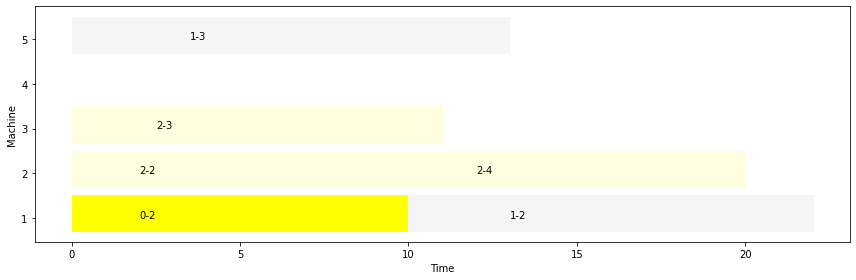

In [95]:
# gantt
# m_cnt = jobDicts['machineCnt']
import datetime
import matplotlib.pyplot as plt
colorbox = ['yellow', 'whitesmoke', 'lightyellow',
            'khaki', 'silver', 'pink', 'lightgreen', 'orange', 'grey', '#8ca8df', 'brown']

for i in range(100):
    colorArr = ['1', '2', '3', '4', '5', '6', '7',
                '8', '9', 'A', 'B', 'C', 'D', 'E', 'F']
    color = ""
    for i in range(6):
        color += colorArr[random.randint(0, 14)]
    colorbox.append("#" + color)

zzl = plt.figure(figsize=(12, 4))

mcnt = 0
for i in gantt:
    for j in i:
        mText = mcnt + 1.5
        mPoint1 = j[1]
        mPoint2 = j[2]
        Word = j[0]
        x1 = mPoint1
        y1 = mText - 0.8
        x2 = mPoint2
        y2 = mText - 0.8
        x3 = mPoint2
        y3 = mText
        x4 = mPoint1
        y4 = mText
        
        color_per_job = int(j[0][:j[0].find('-')])
        plt.fill([x1, x2, x3, x4], [y1, y2, y3, y4],
                 color=colorbox[color_per_job])
        plt.text(0.5 * mPoint1 + 0.5 * mPoint2 - 3, mText - 0.5, Word)
        
        
    mcnt += 1
        
        
plt.xlabel('Time')
plt.ylabel('Machine')
plt.tight_layout()
plt.show()